## A notebook for the Technical Validation part of the paper

## Import and install libraries

In [2]:
%pip install pandas seaborn matplotlib requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import requests
from io import StringIO
import matplotlib.colors as mcolors


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Global settings

In [3]:
# set theme
sns.set_theme(rc={'figure.figsize': (12.7,6.27)})

# Set global font sizes using rcParams
plt.rcParams.update({
    "axes.titlesize": 27,    # Font size for plot titles
    "axes.labelsize": 15,    # Font size for x and y labels
    "xtick.labelsize": 12,   # Font size for x-axis tick labels
    "ytick.labelsize": 12  # Font size for y-axis tick labels
})

## (1) HRA growth over time

In [4]:
# import HRA growth
growth = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.csv")
growth

,group,date,count,order
0,tissue providers,2020-02-10,1,1
1,tissue providers,2020-02-12,1,1
2,tissue providers,2020-05-18,1,1
3,tissue providers,2021-02-10,1,1
4,tissue providers,2021-03-16,2,1
...,...,...,...,...
110,SOPs,2023-10-18,1,10
111,SOPs,2023-12-11,1,10
112,SOPs,2023-12-13,1,10
113,SOPs,2024-06-12,6,10


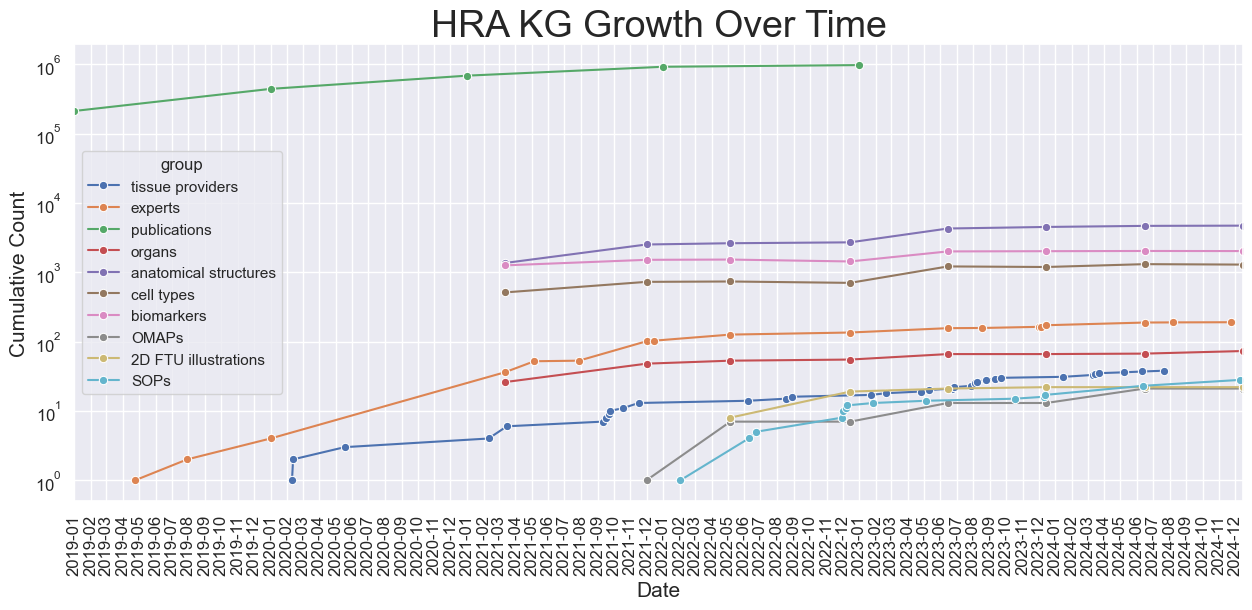

In [5]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.vl.json

# Convert date to datetime
growth['date'] = pd.to_datetime(growth['date'])

# Calculate cumulative sum
growth['cumulative_count'] = growth.groupby("group")['count'].cumsum()

# Create the line plot
sns.lineplot(
    data=growth,
    x='date',
    y='cumulative_count',
    hue='group',
    marker='o'
)

# Customize the plot
plt.title('HRA KG Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Set y-axis to logarithmic scale
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = growth.dropna()
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (2) DOs per organ

In [6]:
# import DOs per organ
dos_per_organ = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.csv")
dos_per_organ

,organ,type,count
0,anatomical systems,ASCT+B Table,1
1,blood,CTAnn Crosswalks,3
2,blood pelvis,ASCT+B Table,1
3,blood vasculature,ASCT+B Table,1
4,blood vasculature,CTAnn Crosswalks,1
...,...,...,...
101,uterus,ASCT+B Table,1
102,uterus,CTAnn Crosswalks,1
103,uterus,3D Reference Organ,2
104,vascular system,CTAnn Crosswalks,1


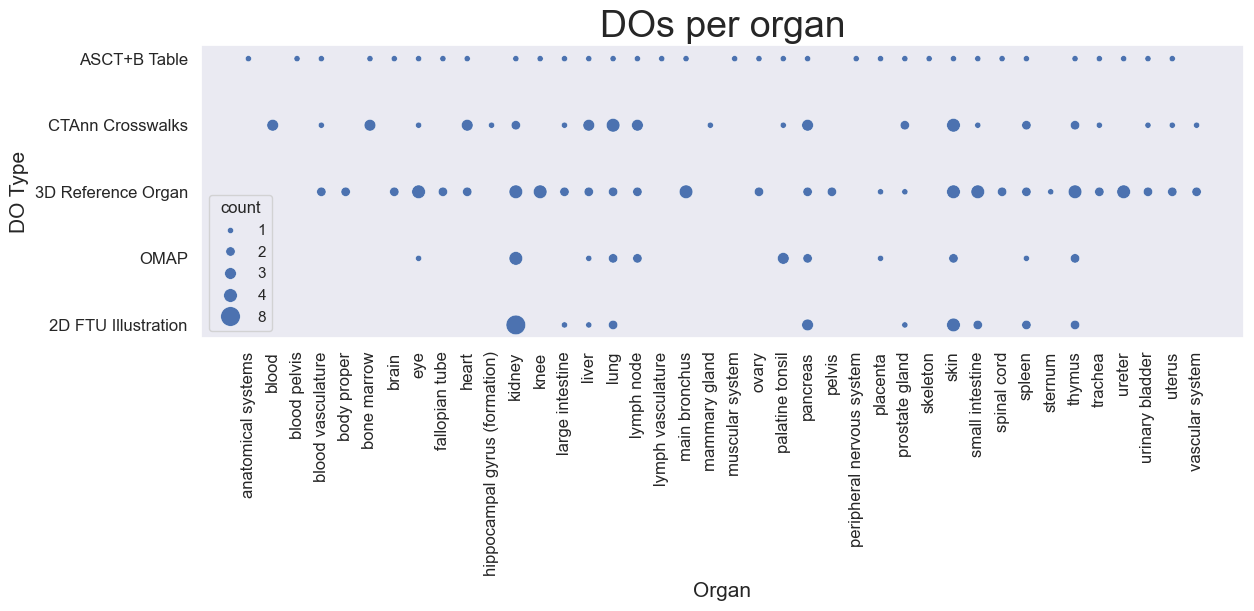

In [7]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

dos_per_organ

color_map = sns.choose_colorbrewer_palette("YlGnBu", as_cmap=True)

# Create the line plot
sns.scatterplot(
    data=dos_per_organ,
   x="organ",
   y="type",
   size="count",
   sizes=(20, 200)
)

# Customize the plot
plt.title('DOs per organ')
plt.xlabel('Organ')
plt.ylabel('DO Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Remove the grid
plt.grid(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (3) Ontology terms added over time

In [8]:
# import ontoloogies extended over time
ontology_terms_added = pd.read_csv("https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.csv")
ontology_terms_added

,date,count,ontology
0,2023-01-01,50,CL
1,2023-02-15,14,CL
2,2023-03-21,11,CL
3,2023-04-20,11,CL
4,2023-05-22,5,CL
5,2023-06-22,7,CL
6,2023-07-20,0,CL
7,2023-08-24,6,CL
8,2023-09-21,2,CL
9,2023-10-19,5,CL


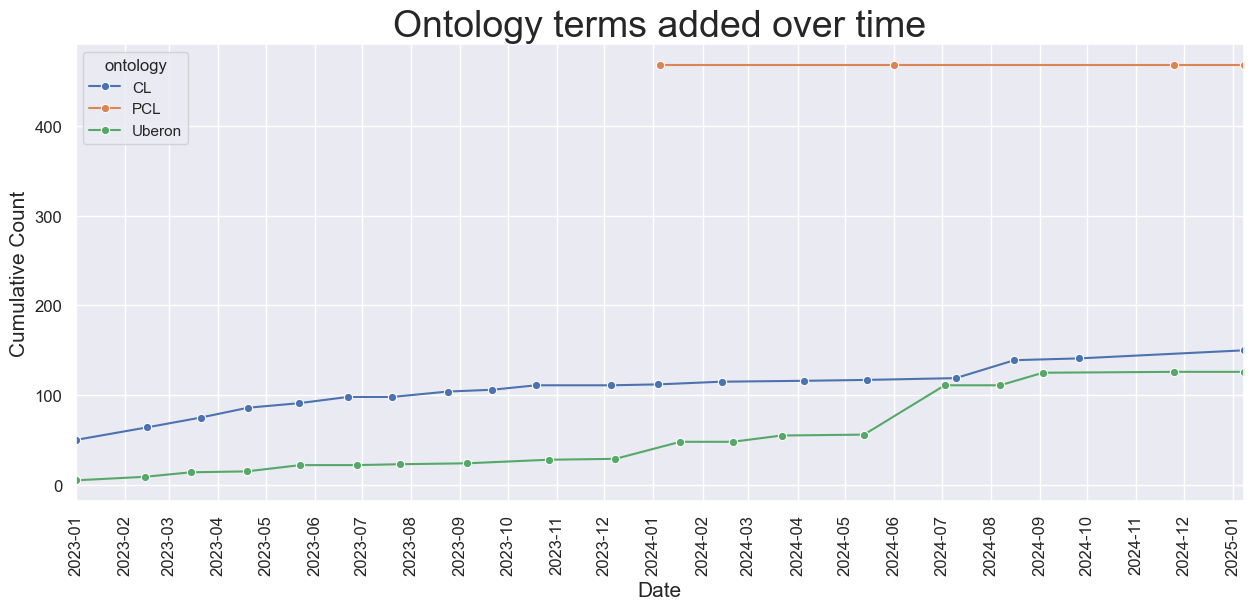

In [9]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.vl.json

# Convert date to datetime
ontology_terms_added['date'] = pd.to_datetime(ontology_terms_added['date'])

# Calculate cumulative sum
ontology_terms_added['cumulative_count'] = ontology_terms_added.groupby("ontology")[
    'count'].cumsum()

# Create the line plot
sns.lineplot(
    data=ontology_terms_added,
    x='date',
    y='cumulative_count',
    hue='ontology',
    marker='o'
)

# Customize the plot
plt.title('Ontology terms added over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = ontology_terms_added.dropna()
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (4) Terms linked to ontologies over time

In [10]:
# GitHub repository details
repo_owner = 'hubmapconsortium'
repo_name = 'ccf-validation-tools'
folder_path = 'reports'
branch = 'master' 

# GitHub API URL to get files in the folder
url = f'https://api.github.com/repos/{repo_owner}/{
    repo_name}/contents/{folder_path}?ref={branch}'

# Fetch the file list from the repository
response = requests.get(url)
files = response.json()

# initlalize list of ds to hold TSV reports
list_df_terms = []
list_df_relationships = []

# Iterate over files and check for TSV files
for file in files:
    if file['name'].endswith('.tsv'):
        # URL for downloading the raw content of the file
        file_url = file['download_url']
        tsv_response = requests.get(file_url)

        # Check if the file is downloaded successfully
        if tsv_response.status_code == 200:
            tsv_data = tsv_response.text

            # Use StringIO to convert the text to a file-like object for pandas to read
            tsv_file = StringIO(tsv_data)

            # Read the TSV file into a DataFrame
            df = pd.read_csv(tsv_file, sep='\t')

            df['Date'] = file['name'].split('_')[len(file['name'].split('_'))-1].replace('.tsv', '')
            
            # put into list depending on file name (terms or relationships)
            if "terms" in file['name']:
              list_df_terms.append(df)
            elif "relationship" in file['name']:
              list_df_relationships.append(df)
        else:
            print(f"Failed to download {file['name']}")
            
print(f'Length of list_df_terms: {len(list_df_terms)}')
print(f'Length of list_df_relationships: {len(list_df_relationships)}')

Length of list_df_terms: 163
Length of list_df_relationships: 161


In [11]:
list_df_terms[5].columns

Index(['Table', 'AS_invalid_term_number', 'AS_invalid_term_percent',
       'CT_invalid_term_number', 'CT_invalid_term_percent', 'Date'],
      dtype='object')

In [12]:
list_df_terms[6].columns

Index(['Table', 'AS_valid_term_number', 'AS_invalid_term_number',
       'AS_invalid_term_percent', 'CT_valid_term_number',
       'CT_invalid_term_number', 'CT_invalid_term_percent', 'Date'],
      dtype='object')

In [13]:
list_df_terms[151].columns

Index(['Table', 'AS_valid_term_number', 'AS_temp_term_number', 'AS_out_ub',
       'AS_invalid_term_number', 'AS_invalid_term_percent',
       'CT_valid_term_number', 'CT_temp_term_number', 'CT_out_ub',
       'CT_invalid_term_number', 'CT_invalid_term_percent',
       'invalid_terms_percent', 'Date'],
      dtype='object')

In [14]:
keep = ['Date', 'Table', 'AS_valid_term_number', 'AS_invalid_term_number',
        'CT_valid_term_number', 'CT_invalid_term_number']

# merge 
merged_df = list_df_terms[6]
  
for i, df in enumerate(list_df_terms[7:],7):
  merged_df = pd.merge(merged_df, df, on=keep, how="outer", suffixes=('_df1' + str(i-1), '_df2' +str(i)))

merged_df = merged_df[keep]

merged_df

,Date,Table,AS_valid_term_number,AS_invalid_term_number,CT_valid_term_number,CT_invalid_term_number
0,20211116,Blood,1,0,28,4
1,20211116,Bone-Marrow,1,0,44,11
2,20211116,Brain,122,63,0,127
3,20211116,Eye,30,2,37,22
4,20211116,Fallopian_tube,13,41,0,22
...,...,...,...,...,...,...
4917,20250129,Thymus,18,0,50,0
4918,20250129,Trachea,20,0,17,0
4919,20250129,Ureter,10,1,4,11
4920,20250129,Urinary_bladder,18,1,17,26


In [15]:
# import AS and CT and B terms linked to ontologies over time:
# get data from https://github.com/hubmapconsortium/ccf-validation-tools/tree/master/reports
# Also: https://docs.google.com/spreadsheets/d/1ShCJ4EKU7W7nvTZutOwW24B9adR7j60iuGKCYkLVHzE/edit?gid=0#gid=0
linked_over_time = pd.read_csv(
    "https://raw.githubusercontent.com/hubmapconsortium/ccf-validation-tools/refs/heads/master/reports/report_terms_20250122.tsv", sep="\t")
linked_over_time

,Table,AS_valid_term_number,AS_temp_term_number,AS_out_ub,AS_invalid_term_number,AS_invalid_term_percent,CT_valid_term_number,CT_temp_term_number,CT_out_ub,CT_invalid_term_number,CT_invalid_term_percent,invalid_terms_percent
0,Anatomical_Systems,104,0,0,0,0.00,0,0,0,0,0.00,0.00
1,Blood,1,0,0,0,0.00,29,0,0,0,0.00,0.00
2,Bone-Marrow,1,0,0,0,0.00,47,0,0,0,0.00,0.00
3,Brain,172,18,0,18,9.47,622,0,0,0,0.00,2.22
4,Eye,39,2,0,2,4.88,33,1,0,1,2.94,4.00
5,Fallopian_tube,9,63,0,63,87.50,18,1,0,1,5.26,70.33
6,Heart,34,0,15,15,30.61,28,0,0,0,0.00,19.48
7,Kidney,59,2,0,2,3.28,67,3,0,3,4.29,3.82
8,Knee,6,0,0,0,0.00,2,9,0,9,81.82,52.94
9,Large_intestine,60,3,0,3,4.76,55,3,0,3,5.17,4.96


In [16]:
# Melt the DataFrame
merged_df_long = merged_df.melt(
    id_vars=['Date','Table'], var_name='Term', value_name='count')
merged_df_long

,Date,Table,Term,count
0,20211116,Blood,AS_valid_term_number,1
1,20211116,Bone-Marrow,AS_valid_term_number,1
2,20211116,Brain,AS_valid_term_number,122
3,20211116,Eye,AS_valid_term_number,30
4,20211116,Fallopian_tube,AS_valid_term_number,13
...,...,...,...,...
19683,20250129,Thymus,CT_invalid_term_number,0
19684,20250129,Trachea,CT_invalid_term_number,0
19685,20250129,Ureter,CT_invalid_term_number,11
19686,20250129,Urinary_bladder,CT_invalid_term_number,26


In [17]:
merged_df_long['Type'] = merged_df_long['Term'].apply(lambda t: "AS" if "AS" in t else "CT")

In [18]:
# Convert date to datetime
merged_df_long['Date'] = pd.to_datetime(
    merged_df_long['Date'], format='%Y%m%d')

merged_df_long['Date']

0       2021-11-16
1       2021-11-16
2       2021-11-16
3       2021-11-16
4       2021-11-16
           ...    
19683   2025-01-29
19684   2025-01-29
19685   2025-01-29
19686   2025-01-29
19687   2025-01-29
Name: Date, Length: 19688, dtype: datetime64[ns]

In [48]:
# prepare filtering
merged_df_long_filtered = merged_df_long

In [49]:
# filter as needed
# remove brain, PNS, blood vasculature
merged_df_long_filtered = merged_df_long[(
    merged_df_long['Table'] != 'Brain') & (merged_df_long['Table'] != 'Peripheral_nervous_system') & (merged_df_long['Table'] != 'Blood_vasculature')]

merged_df_long_filtered

,Date,Table,Term,count,Type,sum_across_tables
0,2021-11-16,Blood,AS_valid_term_number,1,AS,1
1,2021-11-16,Bone-Marrow,AS_valid_term_number,1,AS,2
3,2021-11-16,Eye,AS_valid_term_number,30,AS,154
4,2021-11-16,Fallopian_tube,AS_valid_term_number,13,AS,167
5,2021-11-16,Heart,AS_valid_term_number,24,AS,191
...,...,...,...,...,...,...
19683,2025-01-29,Thymus,CT_invalid_term_number,0,CT,6508
19684,2025-01-29,Trachea,CT_invalid_term_number,0,CT,6508
19685,2025-01-29,Ureter,CT_invalid_term_number,11,CT,6519
19686,2025-01-29,Urinary_bladder,CT_invalid_term_number,26,CT,6545


C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_4400\184742074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_long_filtered['Sum across tables'] = merged_df_long_filtered.groupby(['Date','Table'])[


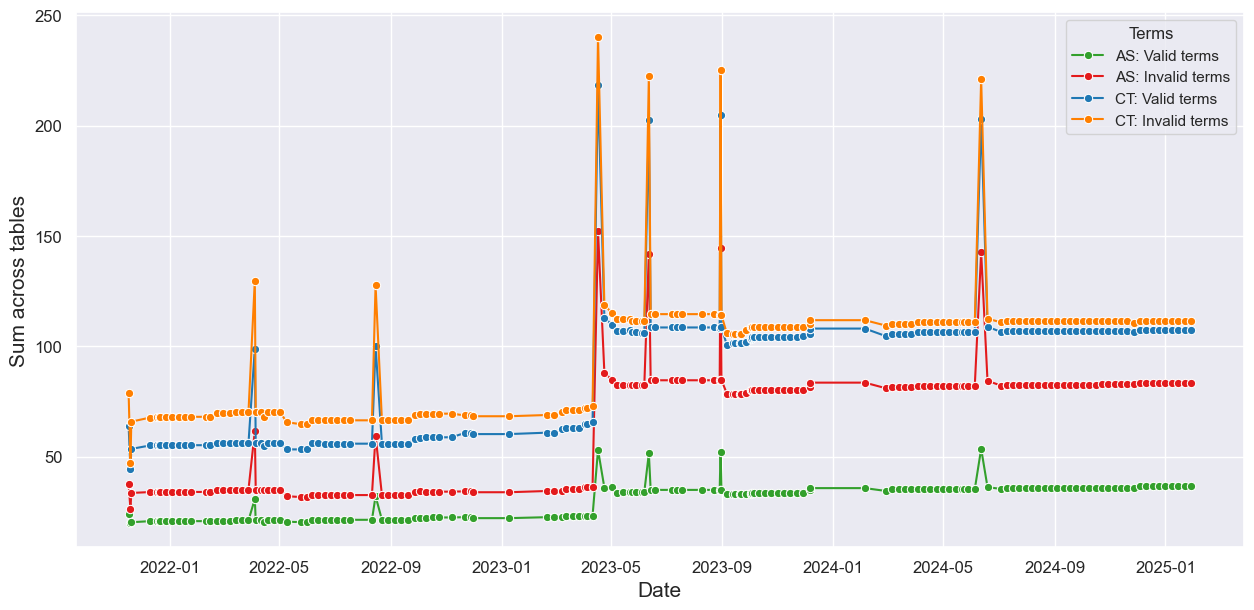

In [51]:
# make combined line graph

# Calculate sum
merged_df_long_filtered['Sum across tables'] = merged_df_long_filtered.groupby(['Date','Table'])[
    'count'].cumsum()

# palette = sns.color_palette('Paired')
palette = ["#33a02c", "#e31a1c", "#1f78b4", "#ff7f00"]

# Create the line plot
sns.lineplot(
    data=merged_df_long_filtered,
    x='Date',
    y='Sum across tables',
    hue='Term',
    errorbar=None,
    palette=palette,
    marker='o'
)

# Customize the plot
plt.legend(labels=['AS: Valid terms', 'AS: Invalid terms',
           'CT: Valid terms', 'CT: Invalid terms'], title='Terms')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

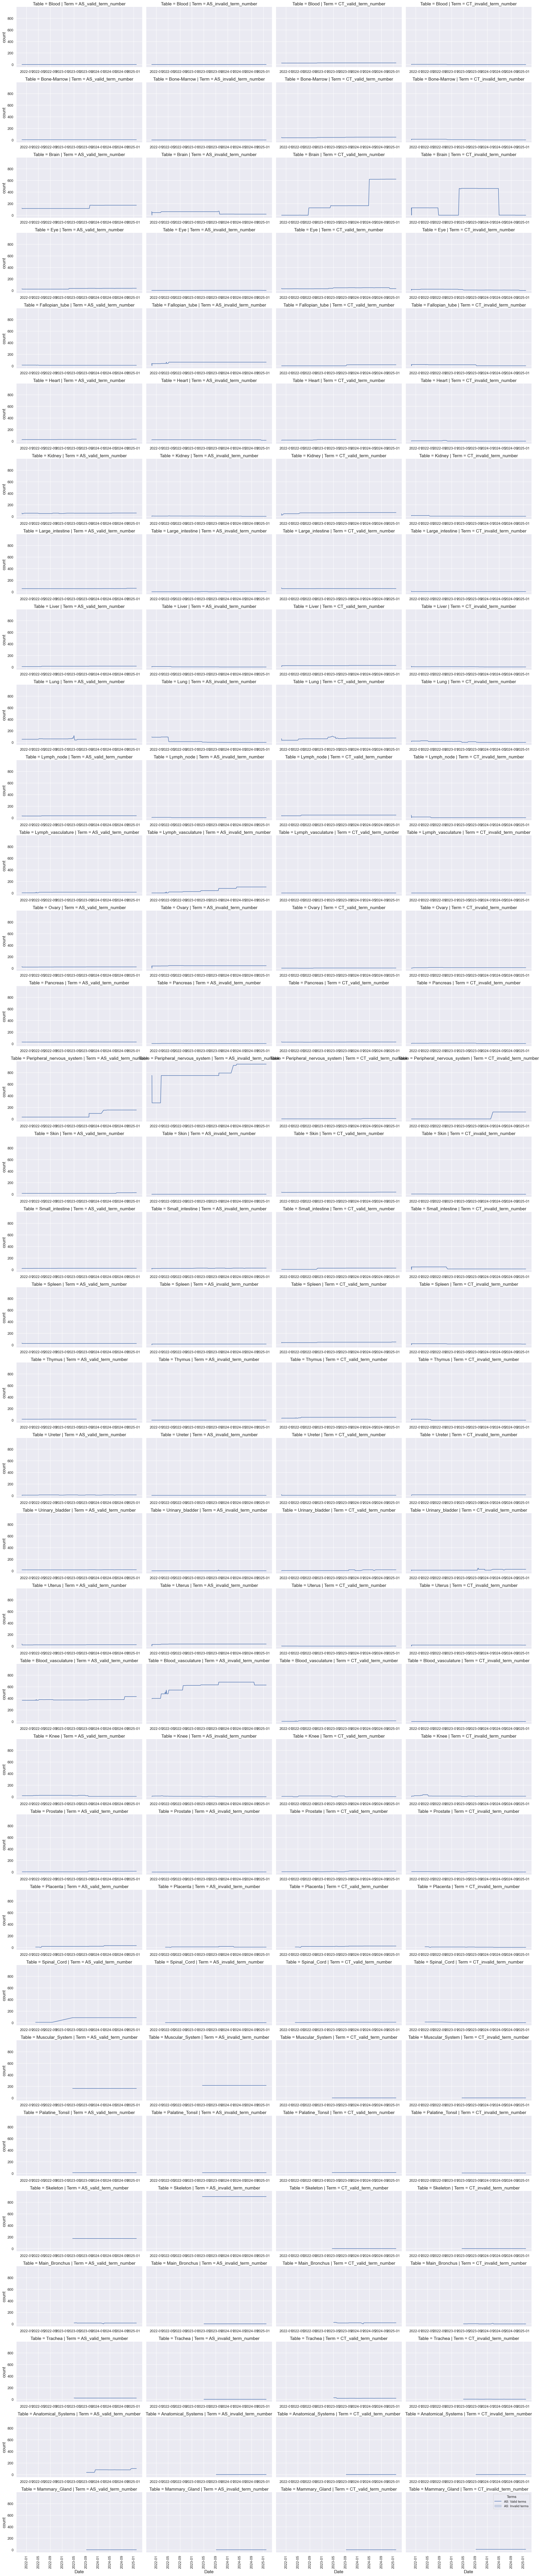

In [ ]:
# no vega-lite spec available

g = sns.relplot(
    data=merged_df_long_filtered,
    x='Date', 
    y='count', 
    row='Table',
    col='Term', 
    # hue="Term", 
    # col_wrap=3,
    kind='line', 
    facet_kws={
      'sharex': True,
      'sharey': True
      }
)

# increase figure size for this one to accommodate col_wrap
g.figure.set_size_inches(25, 120)

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Customize the plot
plt.legend(labels=['AS: Valid terms', 'AS: Invalid terms', 'CT: Valid terms', 'CT: Invalid terms'], title='Terms')

# Rotate x-axis labels for all facets
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.xaxis.set_tick_params(labelbottom=True) # Force labels to be shown

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

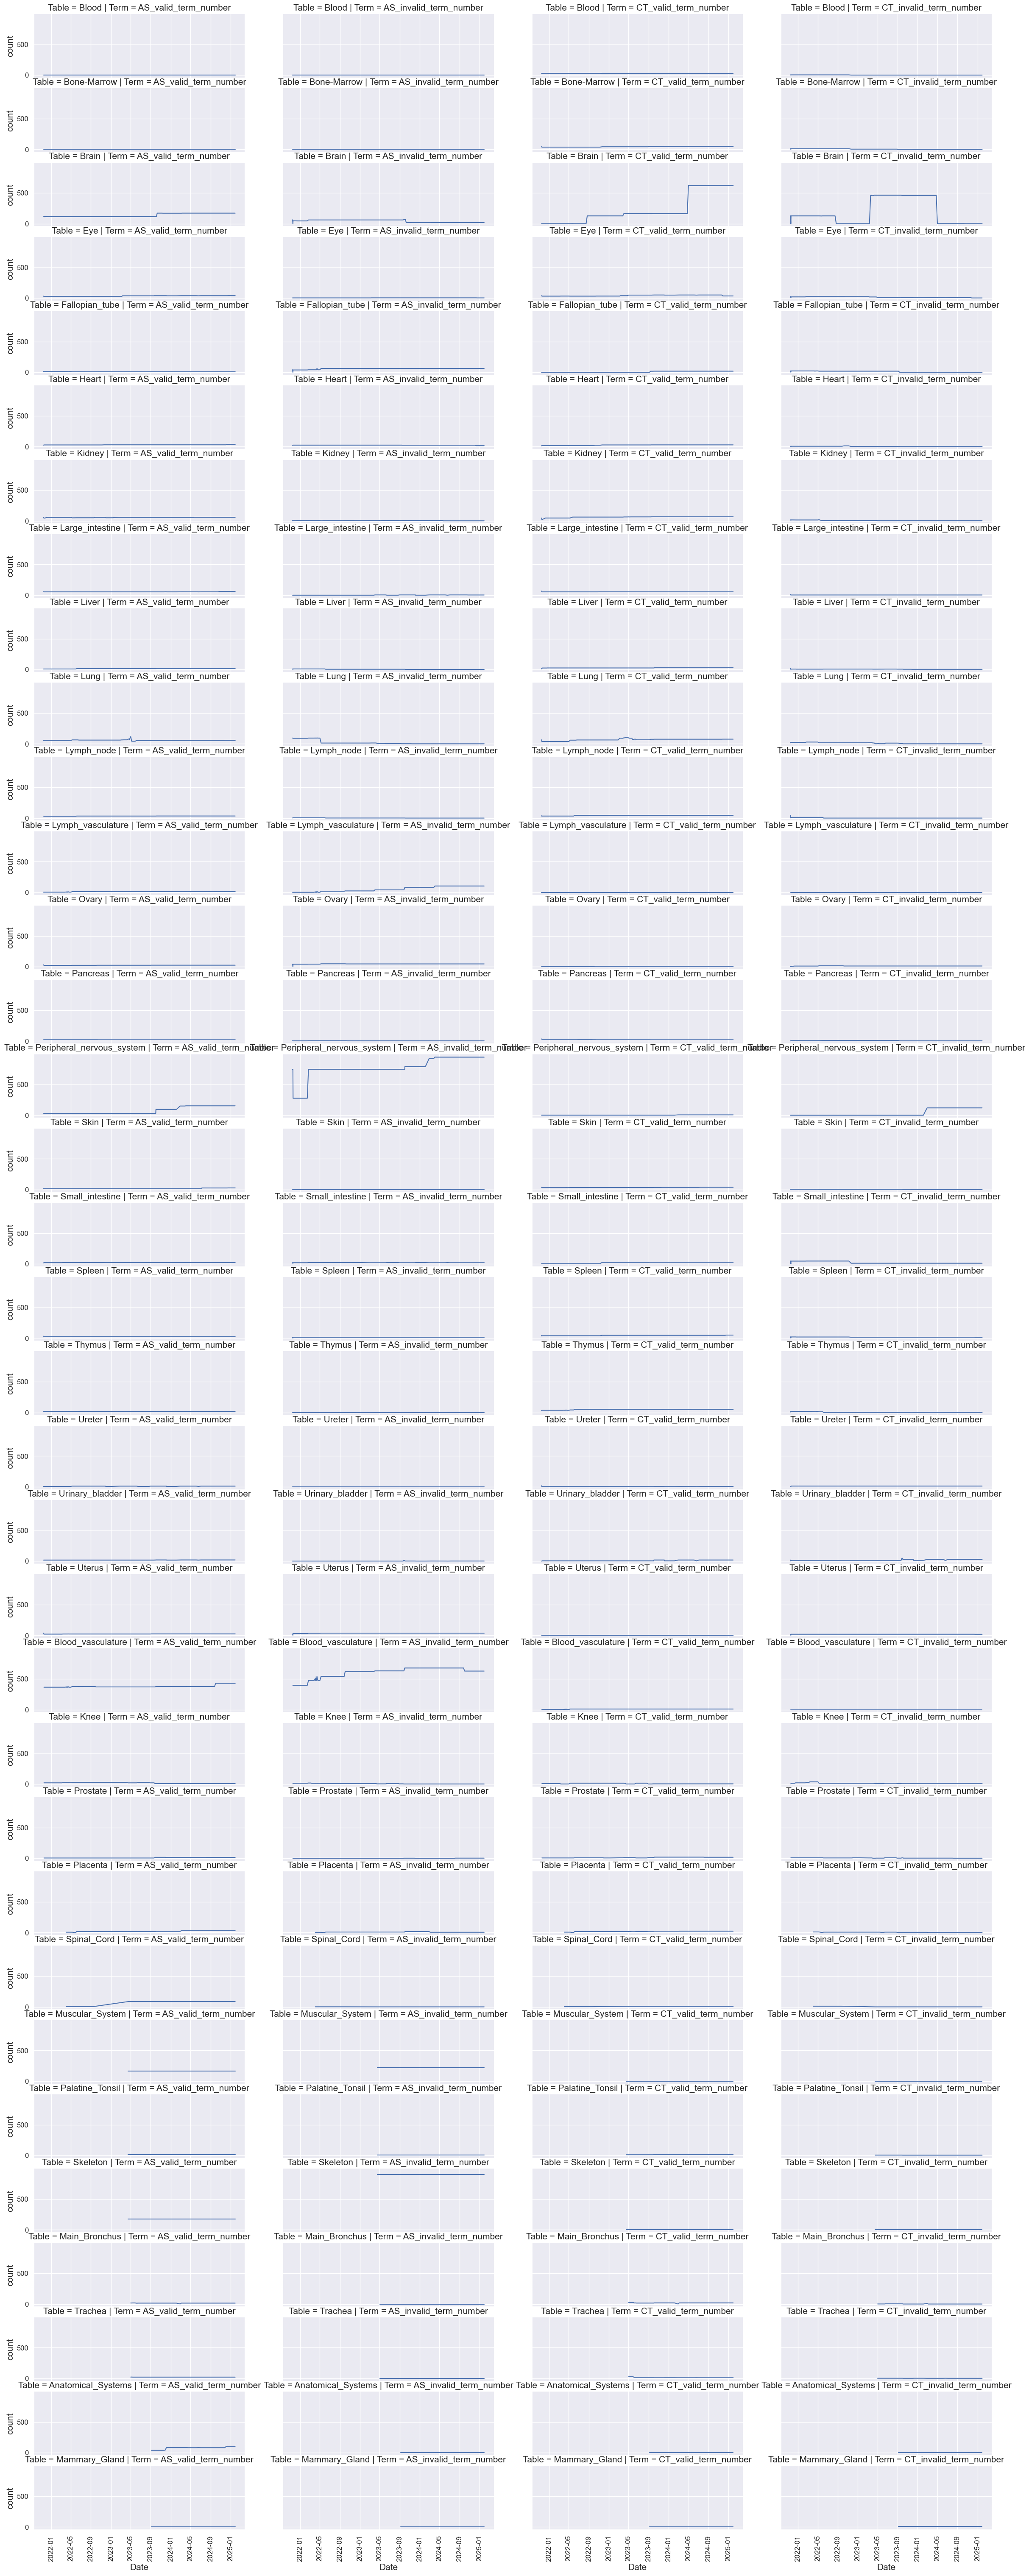

In [33]:
g = sns.FacetGrid(
    merged_df_long_filtered,
  col='Term', 
  row='Table',
  sharey=True, 
  sharex=True)

g.map(
  sns.lineplot, 
  'Date', 
  'count')

# increase figure size for this one to accommodate col_wrap
g.figure.set_size_inches(25, 60)

for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

In [34]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [35]:
hex_values = [mcolors.to_hex(color) for color in sns.color_palette("Paired")]
hex_values

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']